<a href="https://colab.research.google.com/github/Centrattic/SEESZooniverse/blob/main/Copy_of_Planet_Hunters_Project_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PLANET HUNTERS**

**By...**

Rodrigo Augusto Martínez Chávez

Arthur Liese Dessaigne

Kavya Ram

Raylen Chacko

Justin Lee

**Supervisor:**
Sam Akinwande

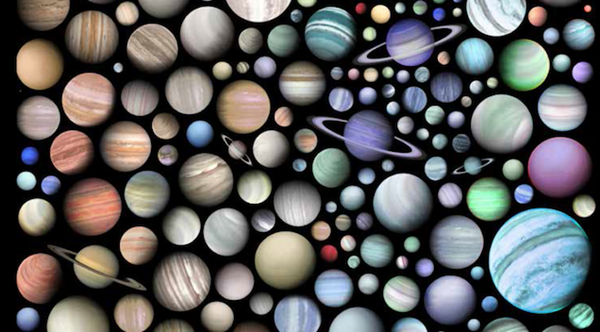

In [ ]:
#@title Run this code to get started
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import warnings
warnings.filterwarnings('ignore')

def analyze_results(model, X_train, y_train, X_test, y_test):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    X_train: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    y_train : array-like of shape (n_samples,)
    Target values for model training.
    X_test: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    y_test : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train)
    plt.show()
    print("Testing:")
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)


df_train = pd.read_csv('exoTrain.csv')
df_train['LABEL'] = df_train['LABEL'] - 1
df_test = pd.read_csv('exoTest.csv')
df_test['LABEL'] = df_test['LABEL'] - 1

exoTrain.csv        100%[===================>] 250.08M   146MB/s    in 1.7s    
exoTest.csv         100%[===================>]  27.57M   111MB/s    in 0.2s    


We've downloaded a NASA dataset from the Kepler Space Telescope! Each row represents measurements of the flux (light intensity) of a particular star. Read more about the dataset [here](https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data).

### Data Visualization

Let's make sure that the data we've extracted has properly loaded. **Please print the length of each dataframe (`df_train` and `df_test`) and the first five values from `df_train`.**


In [ ]:
print("df_train len:", len(df_train))
print("df_test len:", len(df_test))
print("first 5 values of df train\n")
df_train.head()

df_train len: 5087
df_test len: 570
first 5 values of df train



,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


#### Comparing Flux Curves for Exoplanets vs. Non-Exoplanets

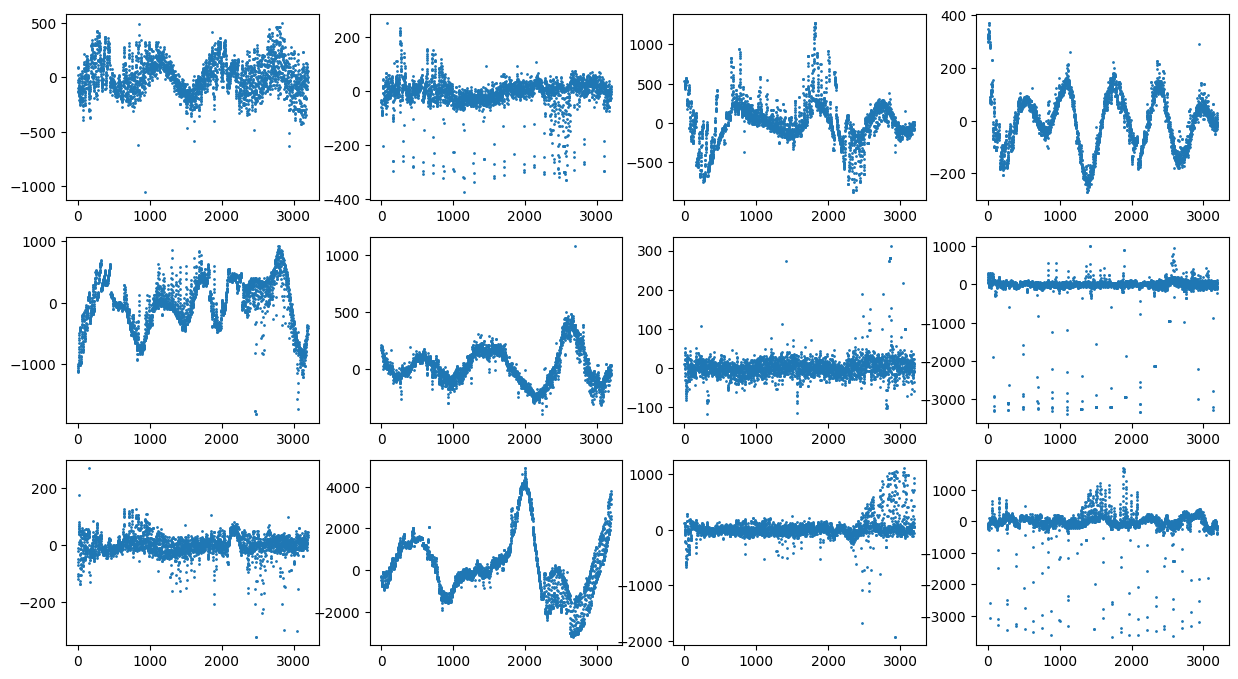

In [ ]:
#@title Run to see samples of exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL'] == 1].iloc[i,1:],s=1)

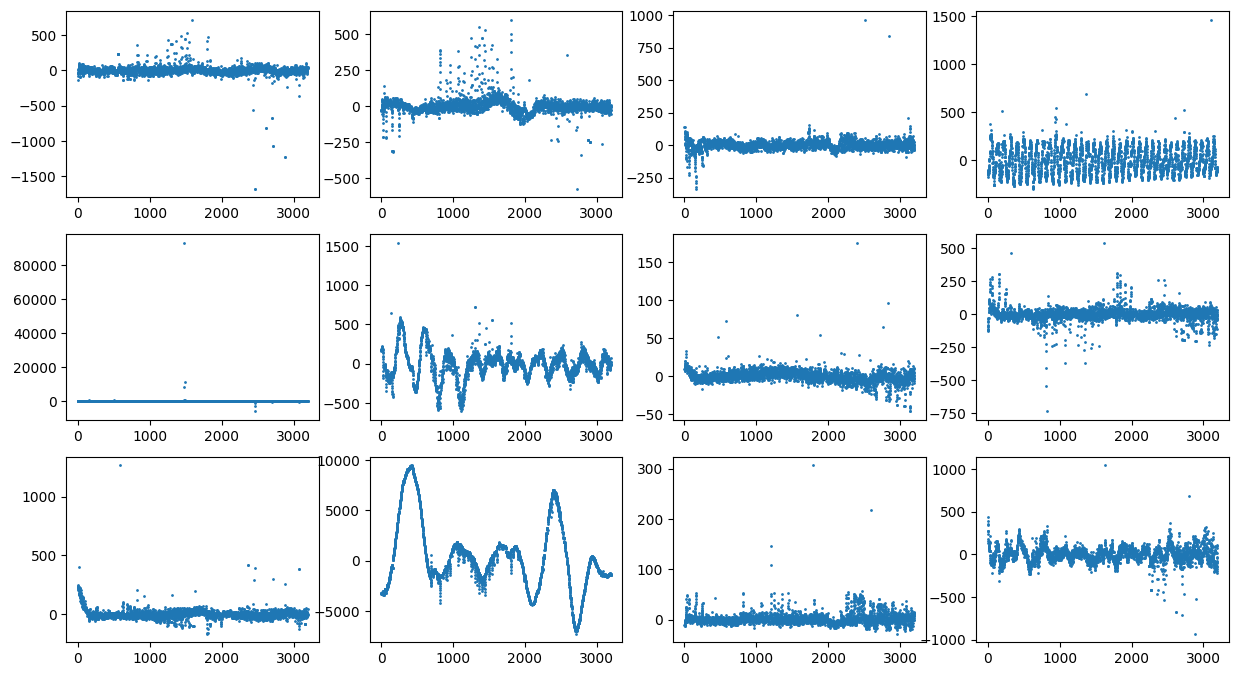

In [ ]:
#@title Run to see samples of non-exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL']==0].iloc[i,1:],s=1)

### Counting Exoplanets

In `df_train`, how many samples are from an exoplanet star? How many are non-exoplanet-stars? How about in `df_test`?

In [ ]:
train_with_exoplanet_samples = df_train.loc[df_train['LABEL'] == 1]
train_with_non_exoplanet_samples = df_train.loc[df_train['LABEL'] == 0]

print("exoplanet samples in train:", len(train_with_exoplanet_samples))
print("non-exoplanet samples in train:", len(train_with_non_exoplanet_samples))

test_with_exoplanet_samples = df_test.loc[df_test['LABEL'] == 1]
test_with_non_exoplanet_samples = df_test.loc[df_test['LABEL'] == 0]

print("exoplanet samples in test:", len(test_with_exoplanet_samples))
print("non-exoplanet samples in test:", len(test_with_non_exoplanet_samples))

exoplanet samples in train: 37
non-exoplanet samples in train: 5050
exoplanet samples in test: 5
non-exoplanet samples in test: 565


Now, please calculate the **portion** of exoplanet stars compared to the total samples, in both the traning data and the testing data.

In [ ]:
print("df_train percent:", len(train_with_exoplanet_samples)/ len(df_train))
print("df_test percent:", len(test_with_exoplanet_samples)/ len(df_test))

df_train percent: 0.007273442107332416
df_test percent: 0.008771929824561403


# Classification with KNN

Now, let's approach our problem as a classification task: based on our flux data, does each data point represent an exoplanet star or a non-exoplanet star?

Before we make our model, run the code cell below to split our data into the familiar `X_train`, `y_train`, `X_test`, `y_test`!

In [ ]:
X_train = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']

X_test = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

#### Step 1: Create our model

Let's start by using a `KNeighborsClassifier` model, which has already been imported from [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [ ]:
# Create a KNN model (will train later)

### YOUR CODE HERE

n_neighbors = 5

model = KNeighborsClassifier(n_neighbors=n_neighbors)

####Step 2: Train our model

Now train the KNN model defined on `X_train` and `y_train` using the `fit` method.

In [ ]:
# Train the Model

model.fit(X_train,y_train)

KNeighborsClassifier()

#### Step 3: Predictions and Accuracy

Now calculate the `train_predictions` and `test_predictions` using the `predict` function from our model. Then print out the results from using `accuracy_score`, previously imported from `sklearn.metrics`. This may take a while to run!

In [ ]:
# Calculate the predictions on X_test using our trained model

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

0.9931197169254964
0.9912280701754386


#### Step 4: Confusion Matrices

Confusion Matrices are helpful in understanding how our model's doing and the kinds of biases it might have - even if it has a high accuracy. This might change how much we trust our model!

Run the cell below to use the `analyze_results` function, which will display these confusion matrices. Feel free to check out the first cell in this notebook for its definition!

-------------------------------------------
Model Results

Training:


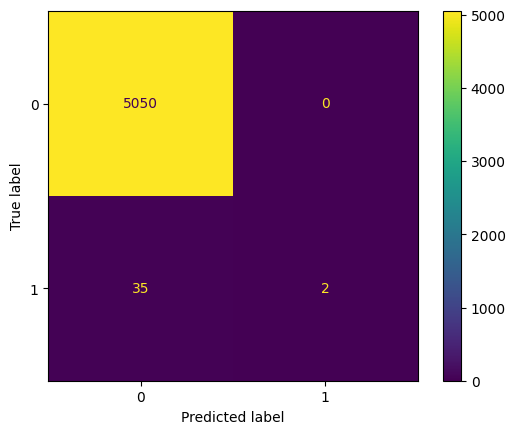

Testing:


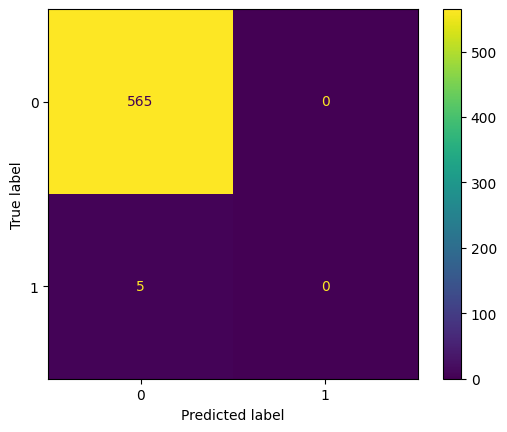

In [ ]:
analyze_results(model, X_train, y_train, X_test, y_test)

# Logistic Regression

You might feel less confident in your KNN model after seeing the confusion matrix! Let's try out some other models.


Here, let's do what we did before, but using a Logistic Regression model instead of a KNN model! Please set up a model using the imported `LogisticRegression` object with `max_iter`=1000.

In [ ]:
# Create a model (will train later)

max_iter = 1000

model = LogisticRegression(max_iter=max_iter)

Now train and analyze your `model` like we did before, using both accuracy and confusion matrices.

0.9272655789266758
0.6508771929824562
-------------------------------------------
Model Results

Training:


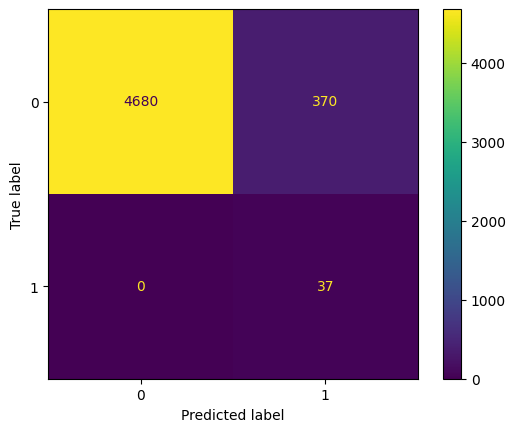

Testing:


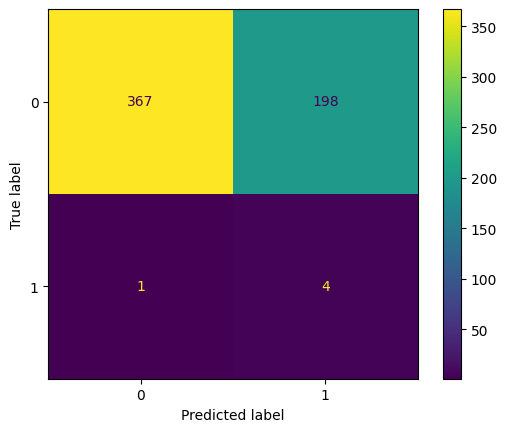

In [ ]:
# Train the model, see accuracies, and analyze the results

model.fit(X_train,y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

analyze_results(model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Decision Tree Model


1.0
0.9842105263157894
-------------------------------------------
Model Results

Training:


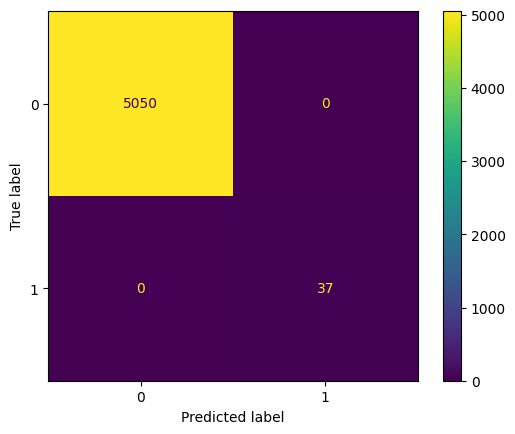

Testing:


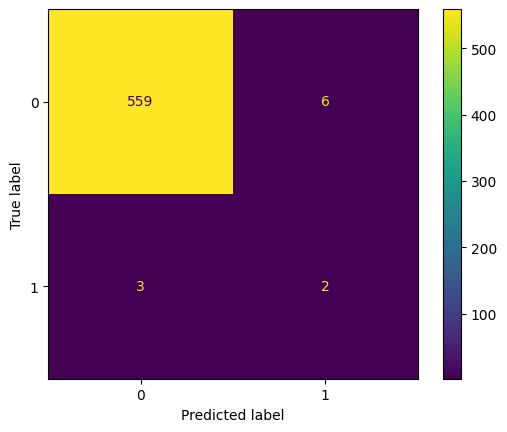

In [ ]:
model = tree.DecisionTreeClassifier()


model.fit(X_train,y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

analyze_results(model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Data Augmentation

In the previous training techniques, we noticed that the models may have had high levels of accuracy, but yielded poor results!

Here, we'll try to improve performance using data augmentation. We'll apply five different augmentation techniques to this dataset, and explore two of these techniques in high detail. Together, we'll explore the use and importance of these two concepts, and compare these results with the previous results we've had as a baseline.


In [ ]:
#@title Run to define helper functions
def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    X_train = np.abs(np.fft.fft(df1, axis=1))
    X_test = np.abs(np.fft.fft(df2, axis=1))
    return X_train,X_test

def norm(df1,df2):
    X_train = normalize(df1)
    X_test = normalize(df2)
    return X_train,X_test

def robust(df1,df2):
    scaler = RobustScaler()
    X_train = scaler.fit_transform(df1)
    X_test = scaler.transform(df2)
    return X_train,X_test

# Normalization


Let's create a function that will help us do this. Explore the functions from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) and use one to help us create a function to `normalize` our `X_train` and `X_test`. Complete the function `norm`.

In [ ]:
def norm(X_train, X_test):
    """
    Helper function to normalize inputs X_train and X_test.

    Args:
    X_train: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    X_test: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.

    Returns:
    X_train: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    X_test: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    """
    minval = np.minimum(np.min(X_train),np.min(X_test))
    maxval = np.maximum(np.max(X_train),np.max(X_test))
    norm_X_train = (X_train-minval)/(maxval-minval)
    norm_X_test = (X_test-minval)/(maxval-minval)
    return norm_X_train, norm_X_test

Now let's apply this concept to our `X_train` and `X_test` variables using the previously defined helper-function called `norm`. We'll use it alongside a couple of other preprocessing functions.

In [ ]:
fourier_X_train, fourier_X_test = fourier(X_train, X_test)
savgol_X_train, savgol_X_test = savgol(fourier_X_train, fourier_X_test)

#####TODO#########
norm_X_train, norm_X_test = norm(savgol_X_train,savgol_X_test)
##################

robust_X_train, robust_X_test = robust(norm_X_train, norm_X_test)

# Data Augmentation with SMOTE


Now to tackle the problem of having an imbalanced dataset! The concept that we'll use to approach this is by synthesizing new data based off of our existing to create a more balanced dataset. Essentially, we'll be creating new datapoints to have more exoplanet samples.

We'll accomplish this by using SMOTE.

SMOTE generates new data for the minority class to help balance the dataset, and to better help define classifcation regions - so the model doesn't always predict the majority class.

Let's now apply this concept by generating new datapoints in robust_X_train and y_train using our predefined helper-function smote.

You might find our graphs looking sigificantly different from the data set we started with! This is the power of data pre-processing with normalization, filters, transformations, and SMOTE, we can both modify our data to look cleaner and also to have more samples in our dataset.

In [ ]:
#####TODO#########
smote_X_train,smote_y_train = smote(robust_X_train, y_train)
##################

In [ ]:
#@title Run to load helper functions and variables
def visualize_data(X, y, indices):
  stars = indices

  fig = plt.figure(figsize=(24,500))
  x = np.array(range(3197))
  for i in range(0, len(stars)):
      ax = fig.add_subplot(100, 5, 1+i)
      ax.set_title('Data ' + "I:" + str(stars[i]) + " Label:" + str(y[stars[i]]))
      ax.scatter(x, X[stars[i],:], s=1)

robust_y_train_with_exoplanet_indices = y_train.to_numpy().nonzero()[0]
robust_y_train_with_no_exoplanet_indices = (y_train - 1).to_numpy().nonzero()[0]

smote_y_train_with_exoplanet_indices = smote_y_train.to_numpy().nonzero()[0]
smote_y_train_with_no_exoplanet_indices = (smote_y_train - 1).to_numpy().nonzero()[0]

Original, newly modified data with exoplanets:


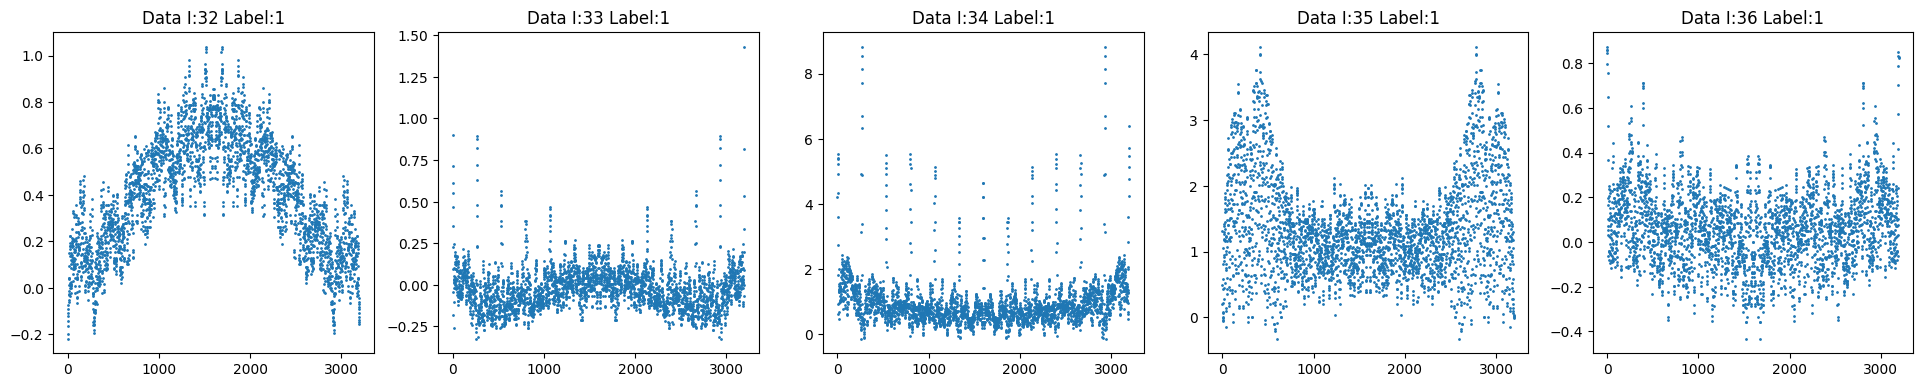

In [ ]:
#@title Run to visualize original, preprocessed data with exoplanets
print("Original, newly modified data with exoplanets:")
visualize_data(robust_X_train, y_train, robust_y_train_with_exoplanet_indices[-5:])

Augmented data with exoplanets:


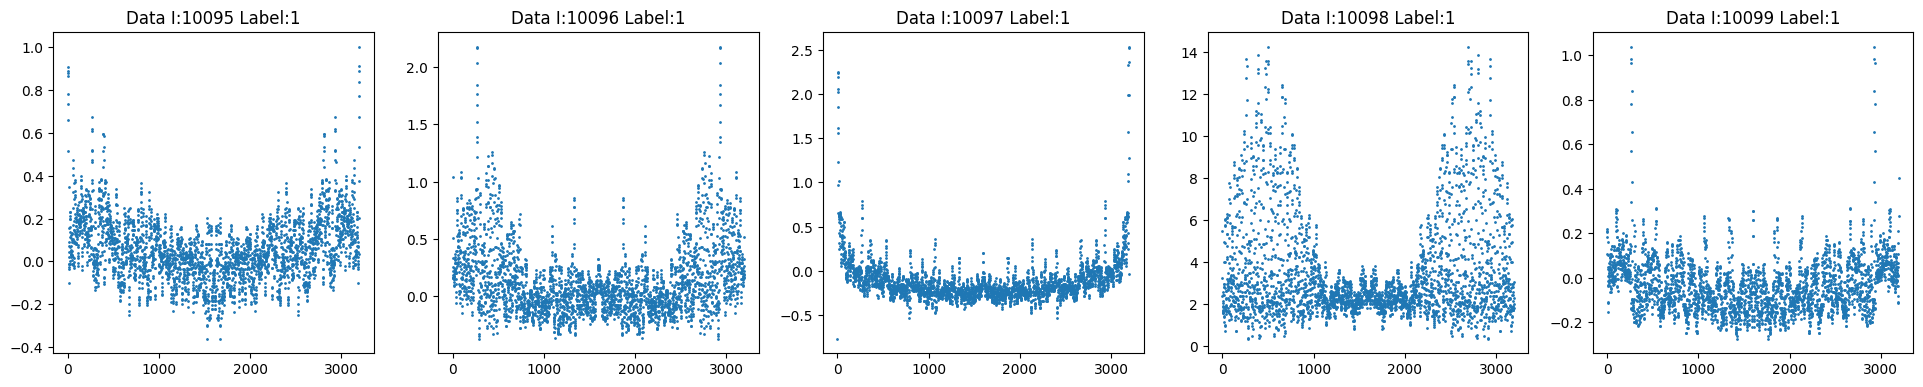

In [ ]:
#@title Run to visualize newly generated data containing exoplanets
print("Augmented data with exoplanets:")
visualize_data(smote_X_train, smote_y_train, smote_y_train_with_exoplanet_indices[-5:])

**How do these plots compare to the plots without SMOTE? What's similar and different about them?**
There's a lot more samples, as indicated by the "i" value at the top.

Original, newly modified data with no exoplanets:


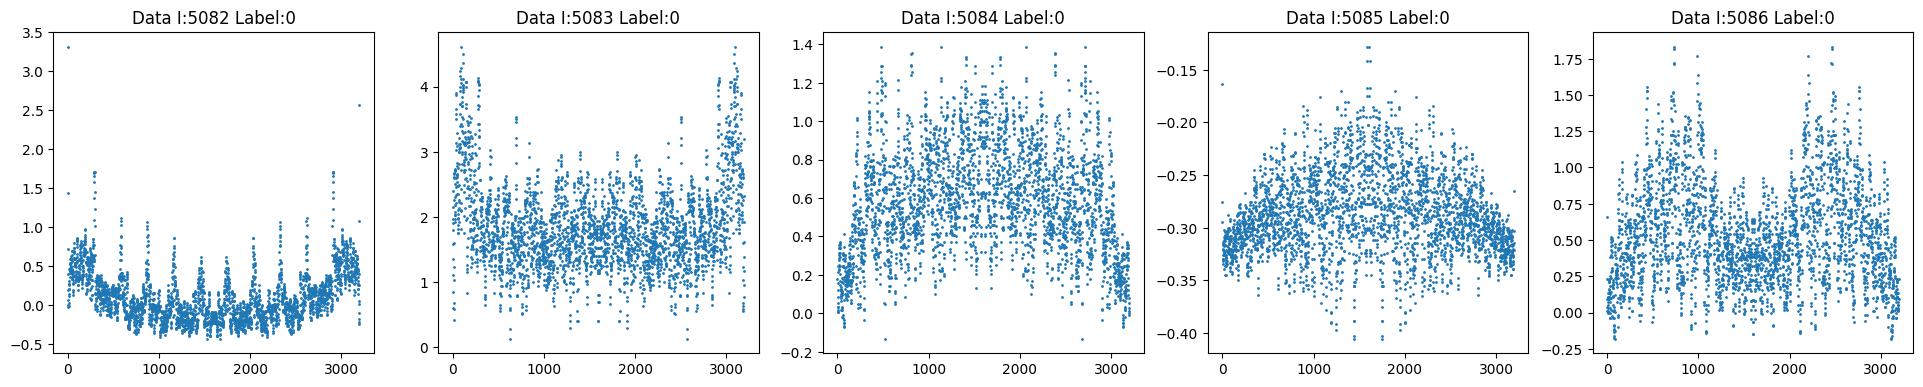

In [ ]:
#@title Run to visualize original, modified data with no Exoplanets
print("Original, newly modified data with no exoplanets:")
visualize_data(robust_X_train, y_train, robust_y_train_with_no_exoplanet_indices[-5:])

Augmented data with no Exoplanets:


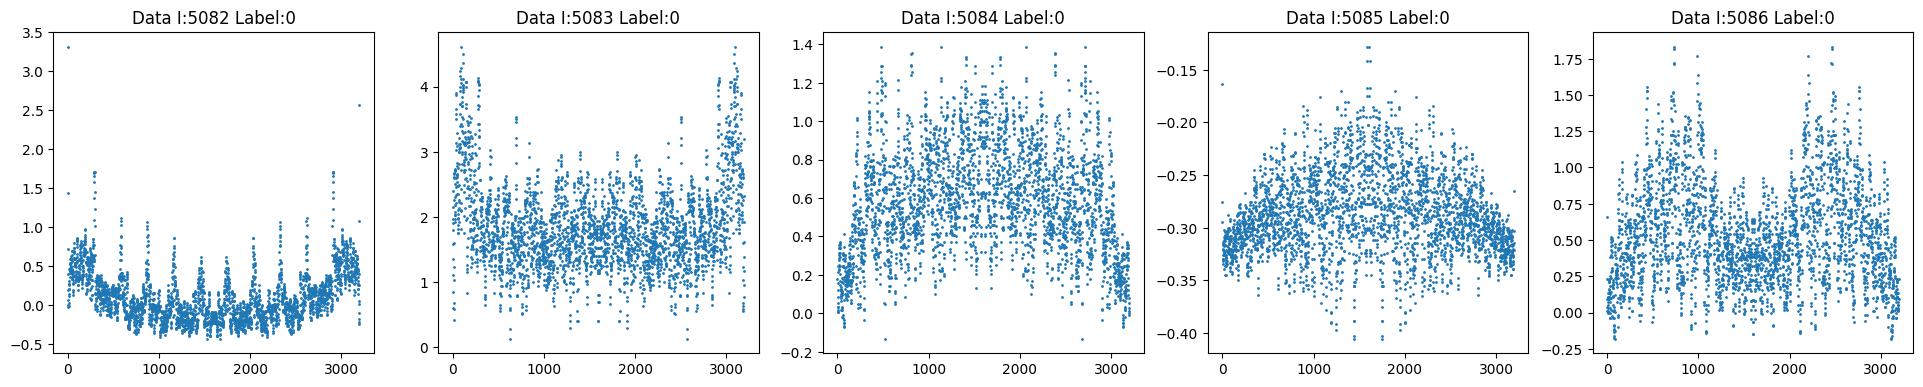

In [ ]:
#@title Run to visualize newly generated data containing no exoplanets
print("Augmented data with no Exoplanets:")
visualize_data(smote_X_train, smote_y_train, smote_y_train_with_no_exoplanet_indices[-5:])

**What's the difference between these plots? Do they look similar — if so, why?**
It's the exact same since this is the non-exoplanet data, which SMOTE doesn't effect (as it's the majority class)

**Explore:** How many training samples do we have now? How many are exoplanet samples? How many are non-exoplanet samples? What things do you notice? What's different?

In [ ]:
print("y_train len:", len(smote_y_train))

number_of_exoplanet_samples = np.count_nonzero(smote_y_train == 1)
number_of_non_exoplanet_samples = np.count_nonzero(smote_y_train == 0)

print("exoplanet samples in y_train:", number_of_exoplanet_samples)
print("non-exoplanet samples in y_train:", number_of_non_exoplanet_samples)

y_train len: 10100
exoplanet samples in y_train: 5050
non-exoplanet samples in y_train: 5050


# Using Augmented Data

Now let's find out how the augmentation affects the results with a past architecture using the new data. Pick the model that performed best from before and re-train it with the new augmented data. How did we do?

## Model 1: Tree Decision Classifier

-------------------------------------------
Model Results

Training:


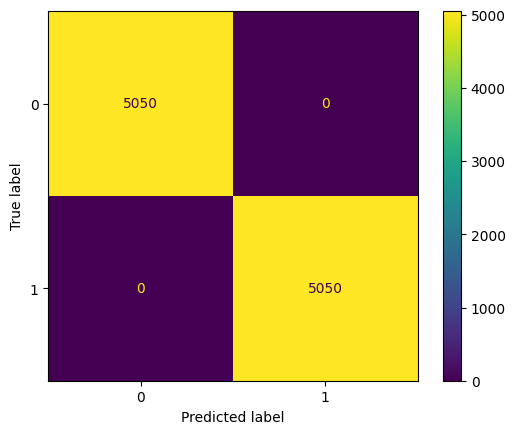

Testing:


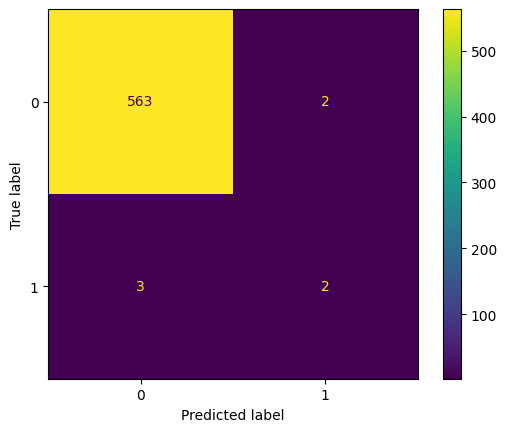

In [ ]:
# Create a model (will train later)

model = tree.DecisionTreeClassifier()
model.fit(smote_X_train, smote_y_train)
analyze_results(model=model, X_train=smote_X_train, y_train=smote_y_train, X_test=robust_X_test, y_test=y_test)

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

0.7806172596815412
0.7736842105263158


## Model 2: Classification with KNN

-------------------------------------------
Model Results

Training:


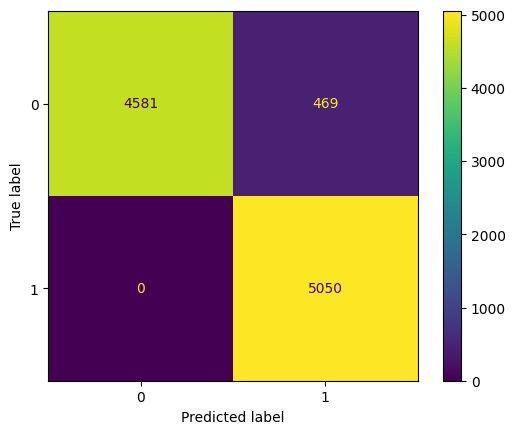

Testing:


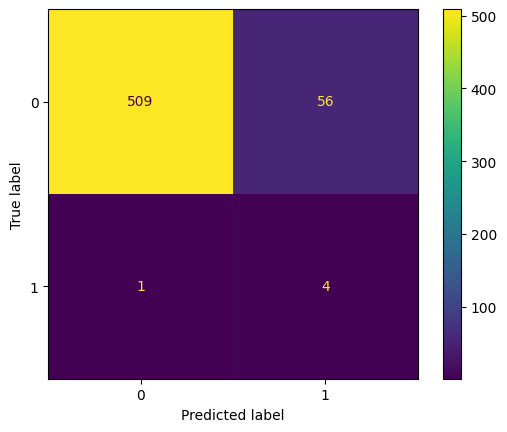

In [ ]:
n_neighbors = 5

model = KNeighborsClassifier(n_neighbors=n_neighbors)
model.fit(smote_X_train, smote_y_train)
analyze_results(model=model, X_train=smote_X_train, y_train=smote_y_train, X_test=robust_X_test, y_test=y_test)

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

0.9425987812069982
0.9596491228070175


## Model 3: Logistic Regression

-------------------------------------------
Model Results

Training:


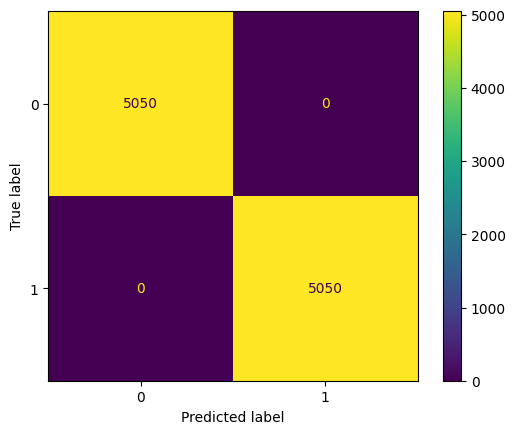

Testing:


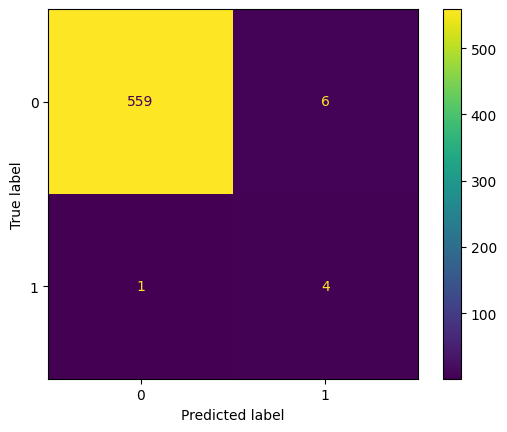

In [ ]:
max_iter = 1000

model = LogisticRegression(max_iter=max_iter)

model.fit(smote_X_train, smote_y_train)
analyze_results(model=model, X_train=smote_X_train, y_train=smote_y_train, X_test=robust_X_test, y_test=y_test)

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

0.5295852172203657
0.5087719298245614


In [ ]:
#@title Run this code to get started
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, BatchNormalization, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df_train = pd.read_csv('exoTrain.csv')
df_train['LABEL'] = df_train['LABEL'] -1
df_test = pd.read_csv('exoTest.csv')
df_test['LABEL'] = df_test['LABEL'] - 1

def plot_graphs(history, best):

  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def analyze_results(model, X_train, y_train, X_test, y_test):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    X_train: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    y_train : array-like of shape (n_samples,)
    Target values for model training.
    X_test: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    y_test : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    if type(model) == keras.src.engine.sequential.Sequential:
      train_predictions = model.predict(X_train)
      train_predictions = (train_predictions > 0.5)
      cm = confusion_matrix(y_train, train_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      plt.close()
      ConfusionMatrixDisplay.from_estimator(model,X_train,y_train)
      plt.show()

    print("Testing:")
    if type(model) == keras.src.engine.sequential.Sequential:
      test_predictions = model.predict(X_test)
      test_predictions = (test_predictions > 0.5)
      cm = confusion_matrix(y_test, test_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

X_train = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

exoTrain.csv        100%[===================>] 250.08M   165MB/s    in 1.5s    
exoTest.csv         100%[===================>]  27.57M  88.0MB/s    in 0.3s    


In [ ]:
#@title Run this code to preprocess data

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    X_train = np.abs(np.fft.fft(df1, axis=1))
    X_test = np.abs(np.fft.fft(df2, axis=1))
    return X_train,X_test

def norm(df1,df2):
    X_train = normalize(df1)
    X_test = normalize(df2)
    return X_train,X_test

def robust(df1,df2):
    scaler = RobustScaler()
    X_train = scaler.fit_transform(df1)
    X_test = scaler.transform(df2)
    return X_train,X_test

fourier_X_train, fourier_X_test = fourier(X_train, X_test)
savgol_X_train, savgol_X_test = savgol(fourier_X_train, fourier_X_test)
norm_X_train, norm_X_test = norm(savgol_X_train,savgol_X_test)
robust_X_train, robust_X_test = robust(norm_X_train, norm_X_test)
smote_X_train,smote_y_train = smote(robust_X_train, y_train)

# Here we're adding the generated, augmented data onto the testing data
# aug_X_train, new_X_test_data, aug_y_train, new_y_test_data = train_test_split(smote_X_train, smote_y_train, test_size=0.3)
# aug_X_test = np.concatenate((robust_X_test, new_X_test_data), axis=0)
# aug_y_test = np.concatenate((y_test, new_y_test_data), axis=0)

## Neural Nets

MLP stands for Multi-layer Perceptron, a specific kind of simple neural network. Thankfully, this is something that `sklearn` supports, and it's already imported as `MLPClassifier`.


![visual](https://s3.amazonaws.com/stackabuse/media/intro-to-neural-networks-scikit-learn-3.png)

Let's complete this by using an `MLPClassifier` model imported by the `sklearn` package. You can view the original documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). Let's create a model with:
1. One hidden layer with 10 units
2. random_state = 1
3. 300 max iterations

In [ ]:
# Create an MLP model (will train later)

model = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(10))

Now, train your model using `smote_X_train` and `smote_y_train`, and analyze its accuracy and confusion matrix!

You have access to all the methods used in the previous part.

0.9992079207920792
0.9947368421052631
-------------------------------------------
Model Results

Training:


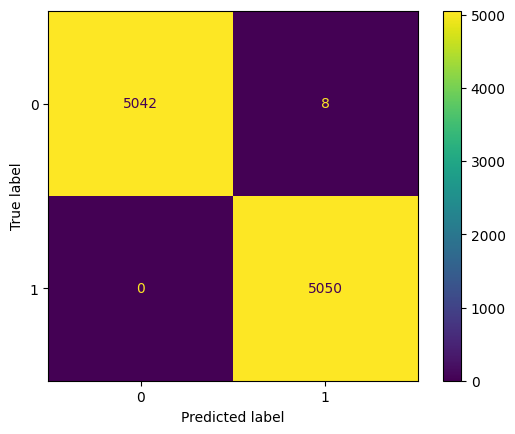

Testing:


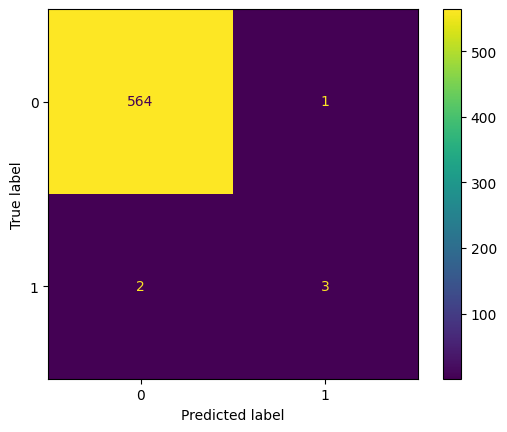

In [ ]:
model.fit(smote_X_train, smote_y_train)

train_predictions = model.predict(smote_X_train)
test_predictions = model.predict(robust_X_test)
print(accuracy_score(smote_y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))
analyze_results(model=model, X_train=smote_X_train, y_train=smote_y_train, X_test=robust_X_test, y_test=y_test)

## Neural Networks (Tensorflow and Keras)

Now let's do what we did before, but using `tensorflow` and `keras`. These libraries will be crucial as they will allow us to create more complex models.

We'll start by creating a similar model using these new packages.

We'll be using a `Sequential` model in order to act as a "list of layers", which we will define to match our previous example. Later, we'll use it to build more complex, advanced models. More information can be found [here](https://keras.io/api/layers/).

1. Add a `Dense` layer with 10 hidden units and a ReLU activation function. This layer also requires an `input_shape` parameter. What should the input shape be?

2. Add a `Dense` layer with 1 hidden unit and a sigmoid activation function. (This will be our output layer)

In [ ]:
# Create an MLP model (will train later)

# First, we initialize our model
model = Sequential()
# then we add a "Dense" (i.e. fully connected) layer
model.add(Dense(10, input_shape=(3197,), activation = "relu")) # for the first layer we specify the input dimensions
# we end by defining the output layer, which has the number of dimensions of the predictions we're making
model.add(Dense(1, activation='sigmoid'))
# we finalize the model by "compiling" it and defining some other hyperparameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now to check the details of your model, run the code block below.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                31980     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31991 (124.96 KB)
Trainable params: 31991 (124.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now train and analyze your `model` like you did before! You'll need to specify these parameters to `fit`:

1. `batch_size` = 64
2. `epochs` = 20
3. `verbose` = 1
4. `validation_data` = (`robust_X_test`, `y_test`)
5. `shuffle` = True

Save the history of the model as it trains or "fits" the data.

Hint:



```
history = model.fit(### YOUR CODE HERE)
```

In [ ]:
# Train and analyze the model
batch_size = 64
epochs = 20
validation_data = (robust_X_test, y_test)
verbose = 1
shuffle = True

history = model.fit(smote_X_train, smote_y_train, batch_size=batch_size, epochs=epochs, verbose=verbose,
                            validation_data=validation_data, shuffle=shuffle)

Epoch 1/20
158/158 [==============================] - 2s 5ms/step - loss: 0.1326 - accuracy: 0.9526 - val_loss: 0.0735 - val_accuracy: 0.9842
Epoch 2/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0420 - accuracy: 0.9861 - val_loss: 0.0592 - val_accuracy: 0.9895
Epoch 3/20
158/158 [==============================] - 1s 3ms/step - loss: 0.0258 - accuracy: 0.9919 - val_loss: 0.0680 - val_accuracy: 0.9877
Epoch 4/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.0888 - val_accuracy: 0.9860
Epoch 5/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0707 - val_accuracy: 0.9895
Epoch 6/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.0734 - val_accuracy: 0.9912
Epoch 7/20
158/158 [==============================] - 1s 3ms/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 0.0933 - val_accuracy: 0.9877
Epoch 

Now we will see how to view the performance of the model as it trained over time!

In addition, we still want to be able to plot the confusion matrix of the model to check for performance and potential class biases. Enter code to analyze the model in the empty portion of the codeblock below.

9/9 [==============================] - 0s 5ms/step - loss: 0.0889 - accuracy: 0.9947


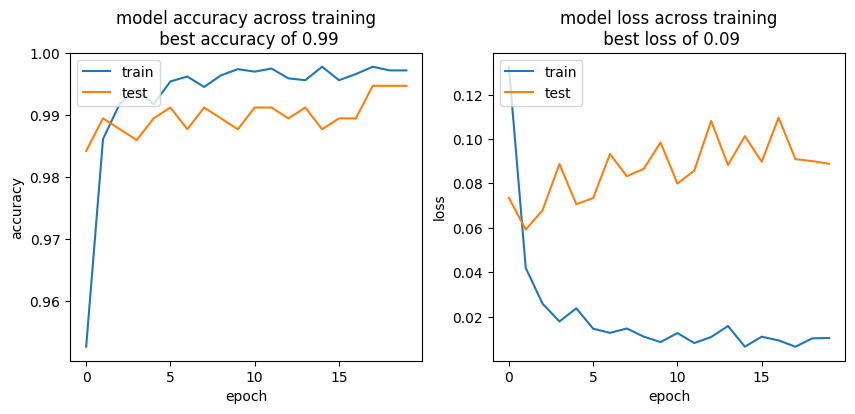

-------------------------------------------
Model Results

Training:
316/316 [==============================] - 1s 3ms/step


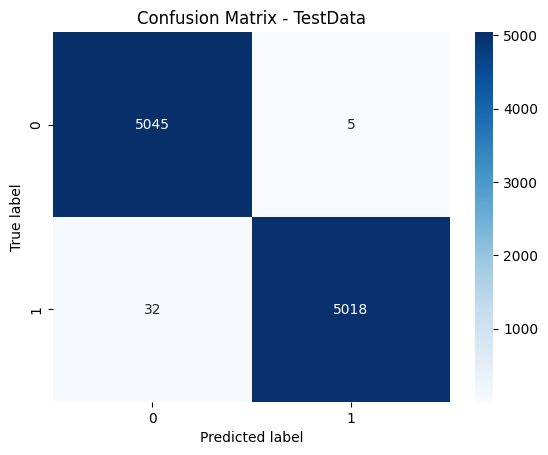

Testing:
18/18 [==============================] - 0s 3ms/step


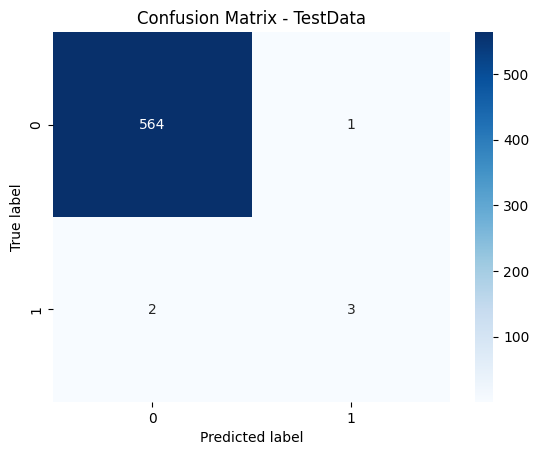

In [ ]:
performance = model.evaluate(robust_X_test, y_test, batch_size=batch_size)
plot_graphs(history, performance)

##############
analyze_results(model=model, X_train=smote_X_train, y_train=smote_y_train, X_test=robust_X_test, y_test=y_test)
##############

## Convolutional Neural Network (CNN)

One potential fault of our previous approach is memorizing the placement of specific patterns in the data. Although we were able to achieve great levels of accuracy, we might benefit from an architecture that can make decisions based on patterns no matter where they occur in the sample - for example, if we started measuring flux earlier or later!

This is something that CNNs excel at. Most CNN architectures are set up to work with two dimensional inputs such as images, so our approach will be a bit different in working with and creating a one-dimensional CNN. However, similar concepts apply as we'll be passing a filter across the each data point with respect to time.

![](https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

First, we'll have to "reshape" our augmented data into a shape that can be fed into a 1-dimensional CNN. We've reshaped the training data below - please **reshape the testing data, too.**

Note: No new information is created, but just the way the information is structured. Because of this, we should have the same number of values present overall with no modifications to the values themselves.

In [ ]:
cnn_smote_X_train = np.expand_dims(smote_X_train, axis=2)
cnn_smote_y_train = smote_y_train

############
cnn_preprocess_X_test = np.expand_dims(robust_X_test, axis=2)
cnn_preprocess_y_test = y_test
############

cnn_X_train = np.expand_dims(X_train, axis=2)
cnn_y_train = y_train

############
cnn_X_test = np.expand_dims(X_test, axis=2)
cnn_y_test = y_test
############

What are the new shapes of the data? The new data is stored in variables: `cnn_smote_X_train`, `cnn_preprocess_X_test`, `cnn_smote_y_train`, `cnn_preprocess_y_test`.

In [ ]:
### YOUR CODE HERE
print(cnn_smote_X_train.shape)
print(cnn_preprocess_X_test.shape)
print(cnn_smote_y_train.shape)
print(cnn_preprocess_y_test.shape)

(10100, 3197, 1)
(570, 3197, 1)
(10100,)
(570,)


Awesome!

Now, we'll be using a `Sequential` model to build up our CNN. Here's a suggestion for an architecture to start with:

1. Add a `Conv1D` layer with 8 output filters, kernal size of 5, relu activation function, and padding = 'same'. This layer also requires an `input_shape` parameter. Does the defined input_shape make sense?

2. Add a `MaxPooling1D` layer with pool_size = 4, strides = 4, and padding = 'same'.

3. Add a `Conv1D` layer with 16 output filters, kernal size of 3, relu activation function, and padding = 'same'.

4. Add a `MaxPooling1D` layer with pool_size = 4, strides = 4, and padding = 'same'.

5. Add a `Flatten` layer.

6. Add a `Dense` layer with 1 hidden unit and a sigmoid activation function. (This will be our output layer)

In [ ]:
# Create model

# First, we initialize our model
model = Sequential()
input_shape = [3197, 1]

cnn_layer_1 = Conv1D(8, 5, activation='relu', input_shape=input_shape, padding='same')
cnn_layer_2 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_3 = Conv1D(16, 3, activation='relu', padding='same')
cnn_layer_4 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_5 = Flatten()
cnn_layer_6 = Dense(1, activation='sigmoid')

# then we add a "Dense" (i.e. fully connected) layer
model.add(cnn_layer_1) # for the first layer we specify the input dimensions
model.add(cnn_layer_2)
model.add(cnn_layer_3)
model.add(cnn_layer_4)
model.add(cnn_layer_5)
model.add(cnn_layer_6)
# we end by defining the output layer, which has the number of dimensions of the predictions we're making
# model.add(Dense(1, activation='sigmoid'))
# we finalize the model by "compiling" it and defining some other hyperparameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now train the model like we did before! (Make sure to use the newly formatted data instead. This will include `cnn_smote_X_train`, `cnn_preprocess_X_test`, `cnn_smote_y_train`, and `cnn_preprocess_y_test`)

In [ ]:
# Train and analyze the model

# Train the model, see accuracies, and analyze the results

#######TODO#########

#training the model
batch_size = 64
epochs = 20
validation_data = (cnn_preprocess_X_test, cnn_preprocess_y_test)
verbose = 1
shuffle = True

history = model.fit(cnn_smote_X_train, cnn_smote_y_train, batch_size=batch_size, epochs=epochs, verbose=verbose,
                            validation_data=validation_data, shuffle=shuffle)

####################

Epoch 1/20
158/158 [==============================] - 14s 81ms/step - loss: 0.2519 - accuracy: 0.9022 - val_loss: 0.1004 - val_accuracy: 0.9737
Epoch 2/20
158/158 [==============================] - 11s 67ms/step - loss: 0.0515 - accuracy: 0.9870 - val_loss: 0.0580 - val_accuracy: 0.9912
Epoch 3/20
158/158 [==============================] - 12s 76ms/step - loss: 0.0254 - accuracy: 0.9952 - val_loss: 0.0514 - val_accuracy: 0.9895
Epoch 4/20
158/158 [==============================] - 12s 79ms/step - loss: 0.0167 - accuracy: 0.9967 - val_loss: 0.0377 - val_accuracy: 0.9947
Epoch 5/20
158/158 [==============================] - 13s 80ms/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.0558 - val_accuracy: 0.9895
Epoch 6/20
158/158 [==============================] - 12s 76ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.0479 - val_accuracy: 0.9912
Epoch 7/20
158/158 [==============================] - 10s 66ms/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.0486 - val_accuracy:

Once again, let's analyze the model's performance over time and the final confusion matrices:

9/9 [==============================] - 0s 29ms/step - loss: 0.0245 - accuracy: 0.9930


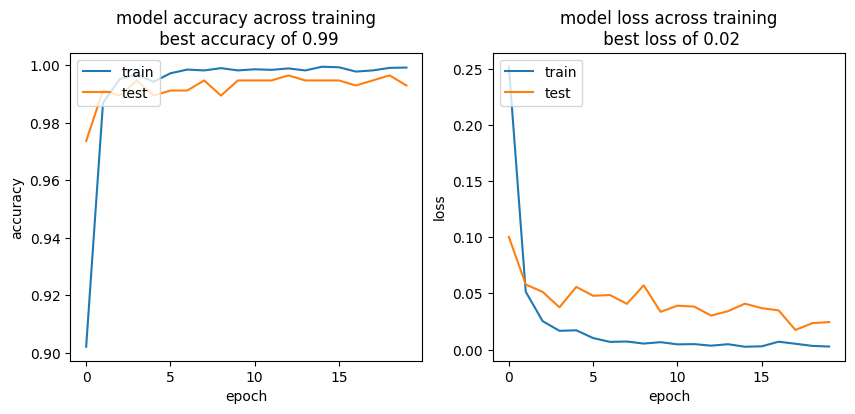

-------------------------------------------
Model Results

Training:
316/316 [==============================] - 8s 24ms/step


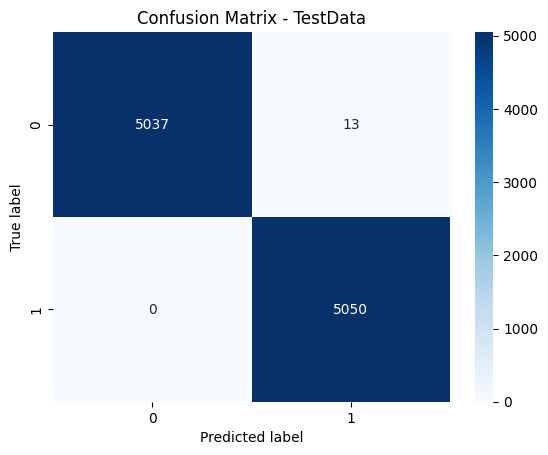

Testing:
18/18 [==============================] - 0s 17ms/step


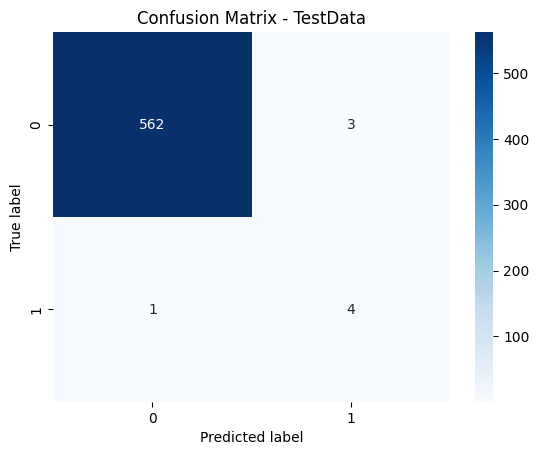

In [ ]:
performance = model.evaluate(cnn_preprocess_X_test, cnn_preprocess_y_test, batch_size=batch_size)
plot_graphs(history, performance)

##############
analyze_results(model=model, X_train=cnn_smote_X_train, y_train=cnn_smote_y_train, X_test=cnn_preprocess_X_test, y_test=cnn_preprocess_y_test)
##############

# **Thank you!**